# More general machines

In [1]:
from tock import *

We've seen finite automata, pushdown automata, and Turing machines, but many other kinds of automata can be created by instantiating a `Machine` directly.

In [2]:
m1 = Machine([BASE, BASE, BASE, BASE], state=0, input=1)

The first argument is required. This machine has four stores, all of type `BASE` (to be explained below).

The argument `state=0` means that store 0 is the state. It's this store that is used to define the start and accept conditions, and this store that is used to define the nodes in a state transition diagram.

The argument `input=1` is required and means that store 1 is the input. When the automaton is run, the input string will be placed on this store.

As with other kinds of machines, you can define a start state, transitions, and accept states using `set_start_state`, `add_transition`, and `add_accept_state`.

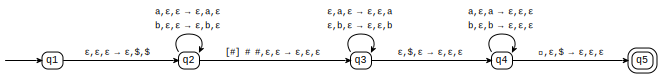

In [3]:
m1.set_start_state('q1')
m1.add_transition('q1, &, &, & -> q2, &, $, $')
m1.add_transition('q2, a, &, & -> q2, &, a, &')
m1.add_transition('q2, b, &, & -> q2, &, b, &')
m1.add_transition('q2, # # #, &, & -> q3, &, &, &')
m1.add_transition('q3, &, a, & -> q3, &, &, a')
m1.add_transition('q3, &, b, & -> q3, &, &, b')
m1.add_transition('q3, &, $, & -> q4, &, &, &')
m1.add_transition('q4, a, &, a -> q4, &, &, &')
m1.add_transition('q4, b, &, b -> q4, &, &, &')
m1.add_transition('q4, _, &, $ -> q5, &, &, &')
m1.add_accept_state('q5')
m1

In [4]:
run(m1, 'a a b # # # a a b').shortest_path()

q1,[a] a b # # # a a b,ε,ε
q2,[a] a b # # # a a b,$,$
q2,[a] b # # # a a b,[a] $,$
q2,[b] # # # a a b,[a] a $,$
q2,[#] # # a a b,[b] a a $,$
q3,[a] a b,[b] a a $,$
q3,[a] a b,[a] a $,[b] $
q3,[a] a b,[a] $,[a] b $
q3,[a] a b,$,[a] a b $
q4,[a] a b,ε,[a] a b $
q4,[a] b,ε,[a] b $


In [5]:
run(m1, 'a a b # # # b a a').has_path()

False

This is something like a 2-stack PDA that recognizes the language $\{w\#\#\#w\}$. It works by transferring the first half of the input to the first stack, transferring the first stack to the second stack (reversing it), then checking the second half of the input against it.

This example also demonstrates that we can read three `#` signs in one transition.

## Store types

### BASE

Our example above demonstrated the BASE store type. We used a BASE store like a stack, and showed that if the lhs of a transition has more than one symbol, it pops that many symbols. Likewise, if the rhs of a transition has more than one symbol, it pushes that many symbols.

Additionally, a BASE store has a head like a Turing machine; it just happens that we left the head in position 0. If the rhs is `^ v`, where `v` is a string, the head moves to the cell to the left of `v`; if the rhs is `v ^`, the head moves to the cell to the right of `v`.

For more information, see the reference section on [Internals](../reference/internals.rst).

### STREAM

The above example looked different from a standard PDA because the right-hand sides of transitions explicitly popped input symbols as they were read. And it had to explicitly check for a blank (`_`) indicating the end of the string before accepting. To make the input look more like a finite or pushdown automaton's, use the store type STREAM.

A store of type STREAM (which only really makes sense for the input store) has two properties.

- Transitions do not have an entry in their right-hand side for STREAMs; it is implicitly `&`.

- The input must be entirely consumed in order for the machine to accept the input string.

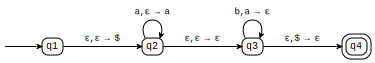

In [6]:
m2 = Machine([BASE, STREAM, BASE], state=0, input=1)
m2.set_start_state('q1')
m2.add_transition('q1, &, & -> q2, $')
m2.add_transition('q2, a, & -> q2, a')
m2.add_transition('q2, &, & -> q3, &')
m2.add_transition('q3, b, a -> q3, &')
m2.add_transition('q3, &, $ -> q4, &')
m2.add_accept_state('q4')
m2

This looks just like a pushdown automaton.

### TAPE

The caret (`^`) notation above can be used to move the head as in a Turing machine, but to get more standard notation, use a store of type `TAPE`. Then the right-hand-side of a transition has two entries for that store, a write and a move (which can be `L` or `R`).

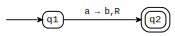

In [7]:
m3 = Machine([BASE, TAPE], state=0, input=1)
m3.set_start_state('q1')
m3.add_transition('q1, a -> q2, b, R')
m3.add_accept_state('q2')
m3

## Low-level interface

Instead of creating an automaton using `set_start_state`, `add_transition`, and `add_accept_state`, you can also directly access the members `start_config`, `transitions`, and `accept_config`.

This interface completely ignores store types. Transitions are created as for BASE stores:

In [8]:
for t in m3.transitions: print(t)

q1,a → q2,b ^


In [9]:
m3.transitions.append(machines.Transition('q1, b -> q2, c ^'))
for t in m3.transitions: print(t)

q1,a → q2,b ^
q1,b → q2,c ^


`start_config` specifies an initial value for every store (not just the state). The initial value for the input is ignored, as it will be replaced by the input string.

In [10]:
m3.start_config

Configuration(stores=(Store(values=('q1',), position=0), Store(values=(), position=0)))

In [12]:
m3.start_config = machines.Configuration('q2, &')
m3.start_config

Configuration(stores=(Store(values=('q2',), position=0), Store(values=(), position=0)))

`accept_configs` is a set of configurations, each which specifies a pattern for every store (not just the state).

In [14]:
for c in m3.accept_configs: print(c)

q2,ε


In [16]:
# accept in state q3 if current symbol is a
m3.accept_configs.add(machines.Configuration('q3, a')) 

This is how STREAM stores are able to require that the input is fully consumed -- by making the accept configuration for the input store to default to a blank (`_`).

In [17]:
for c in m2.accept_configs: print(c)

q4,␣,ε
